# Lab 5: Understanding Variational Autoencoders (VAE)



------------------------------------------------------
*Pablo Santa Cruz Sánchez - 100428988@alumnos.uc3m.es*

*Pablo Tomás Campos Fernández - 100406000@alumnos.uc3m.es*

*Laura Martínez Díaz - 100428953@alumnos.uc3m.es*

------------------------------------------------------

In this notebook, you will complete the code to train a VAE for a dataset of images of celebrities: [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). We will use a reduced set of 11.000 images to speed things up.


### Probabilistic model

The probabilistic model to fit to the data is exactly the same one seen in class. If $\mathbf{x}^{(i)}$ are the training images and $\mathbf{z}^{(i)}$ are the corresponding latent (unobserved) embeddings of dimension $k$, $i=1,\ldots,11.000$. Then ...

\begin{align}
p(\mathbf{z}) &= \mathcal{N}(\mathbf{0},\mathbf{I})\\
p(\mathbf{x}|\mathbf{z}) &= \mathcal{N}(\mu_\theta(\mathbf{z}),\sigma_x\mathbf{I})
\end{align}
where $\mu_\theta(\mathbf{z})$ is a Neural Network with input $\mathbf{z}$ and $\sigma_x$ is a reconstruction noise power that we won't train. By default, we will take the value $\sigma_x=0.1$.

### Inference model

We will approximate the posterior distribution $p(\mathbf{z}|\mathbf{x})$ by the following parametric model

$$p(\mathbf{z}|\mathbf{x})\approx q(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mu_\eta(\mathbf{x}),\text{diag}(\sigma_\eta(\mathbf{x}))$$

where both $\mu_\eta(\mathbf{x}),\text{diag}(\sigma_\eta(\mathbf{x})$ are neural networks with input $\mathbf{x}$.

### Training loss: the evidence lower bound (ELBO)

Since exact inference is intractable in the former model, we will train the parameters of the probabilistic and inference models using the ELBO lower bound

$$\log p(\mathbf{x}) \geq \mathbb{E}_{q(\mathbf{z}|\mathbf{x})}\left[\log p(\mathbf{x}|\mathbf{z})\right] - D_{KL}(q(\mathbf{z}|\mathbf{x}||p(\mathbf{z}))$$

Since $p(\mathbf{z})=\mathcal{N}(\mathbf{0},\mathbf{I})$ and $q(\mathbf{z}|\mathbf{x})$ are both Gaussian then

$$D_{KL}(q(\mathbf{z}|\mathbf{x}||p(\mathbf{z})) = \frac{1}{2}\left(-k+\sum_{j=1}^k \sigma_{\eta,j}-\log(\sigma_{\eta,j})+\mu_{\eta,j}^2\right)$$

During training, the first expectation will be replaced by a one-sample Monte Carlo estimate for every data point. Overall, the ELBO to be optimized using SGD is

$$\text{ELBO}(\theta,\eta,\sigma_x) = \frac{1}{N} \sum_{i=1}^{N} \left(\log p(\mathbf{x}^{(i)}|\tilde{\mathbf{z}}^{(i)}) - D_{KL}(q(\mathbf{z}|\mathbf{x}^{(i)}||p(\mathbf{z}))\right)$$

where $\tilde{\mathbf{z}}^{(i)}$ is a sample from $q(\mathbf{z}|\mathbf{x}^{(i)})$ computed as

$$\tilde{\mathbf{z}}^{(i)} =  \mu_\eta(\mathbf{x}) + \sqrt{\sigma_\eta(\mathbf{x})} \epsilon$$
and $\epsilon$ is a sample from a k-dimensional standard Gaussian distribution. This is the **reparameterization trick**. Note that samples are differentiable w.r.t. the parameters in both $\mu_\eta(\mathbf{x})$ and $\sigma_\eta(\mathbf{x})$.

In [ ]:
import torch
from torch import nn
import numpy as np
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch import optim
import time

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Part I: Loading the reduced CelebA dataset

First, import to your own Drive the folder I shared with you in Aula Global.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_to_folder = '/content/drive/MyDrive/UC3M/1º MASTER/DEEP LEARNING/Lab 1. Deep probabilistic modeling-20231114/reduced_celebA/' # UPDATE THIS ACCORDING TO YOUR PATH!

With the following function we import the database using Pytorch dataloaders ...

In [ ]:
def get_celeba(batch_size, dataset_directory):

    train_transformation = transforms.Compose([
        transforms.Resize((64, 64)),        # THE IMAGES ARE RE-SCALED TO 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    train_dataset = torchvision.datasets.ImageFolder(dataset_directory + 'celeba', train_transformation)


    # Use sampler for randomization
    training_sampler = torch.utils.data.SubsetRandomSampler(range(len(train_dataset)))

    # Prepare Data Loaders for training and validation
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=training_sampler)

    return trainloader

# We load the database in a single trainloader

In [ ]:
trainloader = get_celeba(32,path_to_folder)

In the following code, we read one mini-batch of images and plot some of them.

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize to pot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

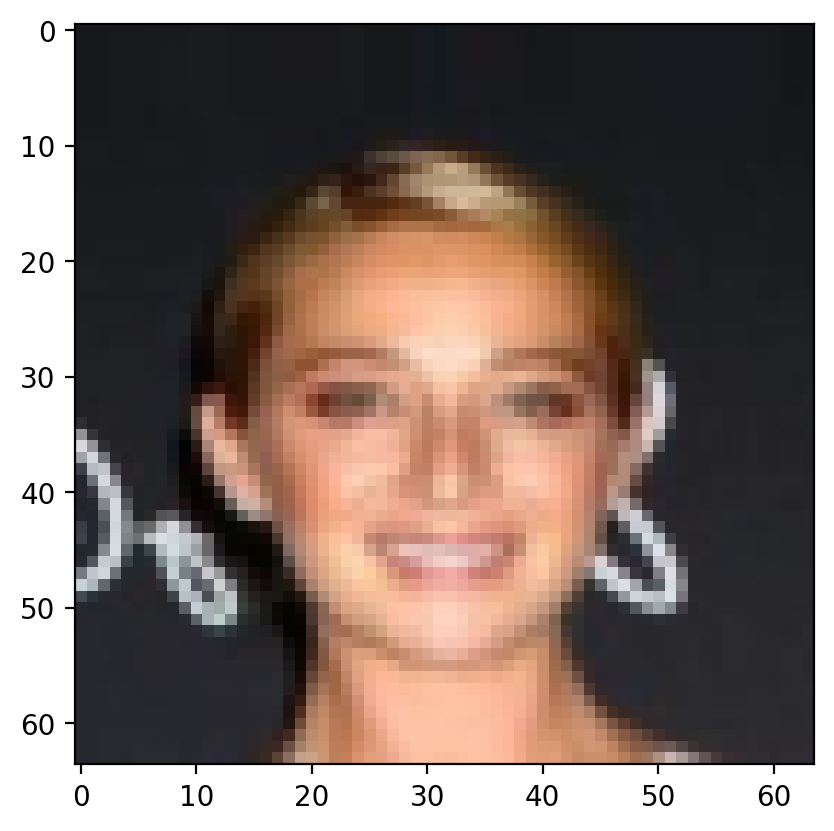

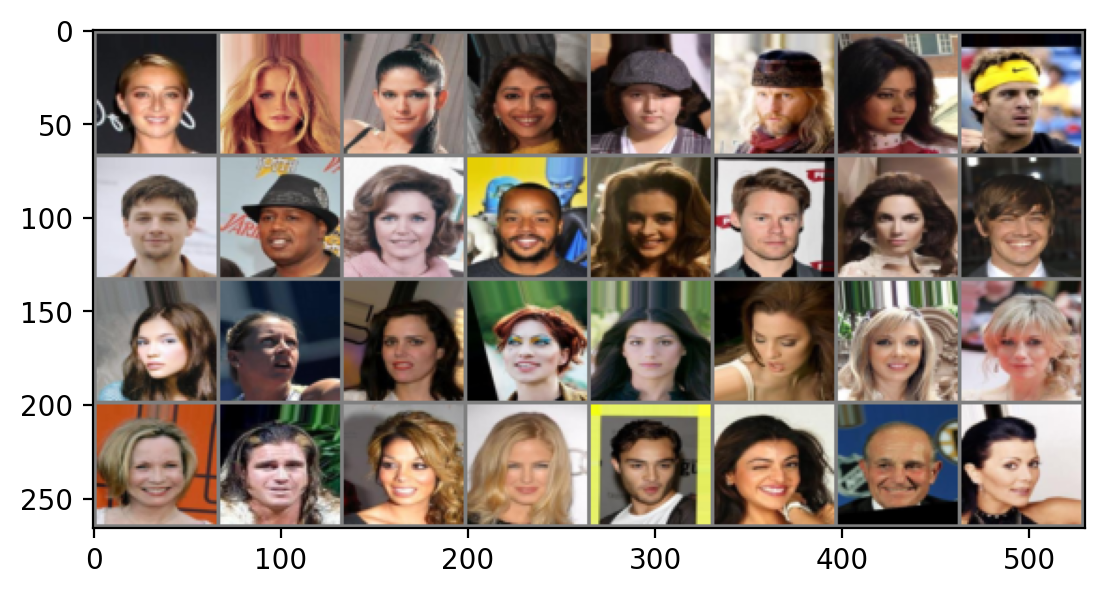

In [ ]:
train = iter(trainloader)

i,l = next(train)

imshow(i[0,:,:,:])

imshow(torchvision.utils.make_grid(i))

## A class to implement the encoder mean and variance

With the following class, we implement the CNN network to obtain both $\mu_\eta(\mathbf{x}), \sigma_\eta(\mathbf{x})$, which determine the moments of the approximate posterior distribution $q(\mathbf{z}|\mathbf{x})$.

We use a single CNN with input $\mathbf{x}$, the output vector of dimension $2k$ is divided in two parts. The first $k$ elements represent the mean, and we compute the variance from the last $k$ elements using a soft-plus.

The actual design of this network is borrowed from [this paper](https://paperswithcode.com/method/beta-vae). It could be improved by adding batch norm layers, but you will see it does perform well already.

> **Exercise**: Complete the following code. What are the spatial dimensions of the 256 feature maps at the ouput of the `conv5` convolutional layer?

In [ ]:
class encoder(nn.Module):

    def __init__(self,dimz,channels=3,var_x=0.1):


        super().__init__()

        self.dimz = dimz    #dimz is k, the dimension of the latent space

        # self.conv1 is a convolutional layer, with 32 output channels, kernel size 4, stride 2,
        # and padding 1

        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=32,
                               kernel_size=4, stride=2, padding=1)

        self.relu = nn.ReLU()

        # self.conv2 is a convolutional layer, with 32 output channels, kernel size 4, stride 2,
        # and padding 1

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32,
                               kernel_size=4, stride=2, padding=1) #YOUR CODE HERE

        # self.conv3 is a convolutional layer, with 64 output channels, kernel size 4, stride 2,
        # and padding 1

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64,
                               kernel_size=4, stride=2, padding=1)

        # self.conv4 is a convolutional layer, with 64 output channels, kernel size 4, stride 2,
        # and padding 1

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64,
                               kernel_size=4, stride=2, padding=1) #YOUR CODE HERE

        # self.conv5 is a convolutional layer, with 256 output channels, kernel size 4, stride 1,
        # and padding 0

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=256,
                               kernel_size=4, stride=1, padding=0)


        # self.linear is a linear layer with dimz*2 outputs
        self.linear = nn.Linear(256, self.dimz*2)

        self.softplus = nn.Softplus()

    def forward(self,x):

        # The forward method to project and image into a 2dimz dimensional vector

        z = self.relu(self.conv1(x))
        z = self.relu(self.conv2(z))
        z = self.relu(self.conv3(z))
        z = self.relu(self.conv4(z))
        z = self.relu(self.conv5(z))
        # Transform z into a 256-dim vector
        z = nn.Flatten()(z)
        z = self.linear(z)

        return z

    def encode_and_sample(self,x,flag_sample=True):

        # This methods compute both the posterior mean and variance
        # Also we obtain a sample from the posterior using the
        # reparameterization trick.

        # We obtain the encoder projection using the forward method

        z = self.forward(x)

        # The mean is the first dimz components of the forward output

        mu = z[:, :self.dimz]

        # We compute the variance from the last dimz components using a
        # soft plus
        var = self.softplus(0.5 * z[:, self.dimz:])
        sample = None

        if(flag_sample==True):

            eps = torch.randn_like(var)

            sample = mu + eps*(var**0.5)

        return mu,var,sample


> **Exercise**: Using `dimz=2`, create an encoder object and print the mean `mu_z` and variance `var z` in the z space for one image.

In [ ]:
encoder_model = encoder(2)
mu_z, var_z, sample = encoder_model.encode_and_sample(i)


## A class to implement the decoder mean

Given a sample from $\mathbf{z}$, we generate images by sample from $p(\mathbf{x}|\mathbf{z}) = \mathcal{N}(\mu_\theta(\mathbf{z}),\sigma_x\mathbf{I})$, where we take $\sigma_x=0.1$ as a reconstruction noise. The following class implements the mean NN $\mu_\theta(\mathbf{z})$ using transpose convolutions. Again, the network design comes from the same [this paper](https://paperswithcode.com/method/beta-vae).

> **Exercise**: complete the following code. Why do we use an hiperbolic tangent output activation?


In [ ]:
class decoder(nn.Module):

    def __init__(self,dimz,channels=3,var_x=0.1):

        super().__init__()

        # We expand z into a 256 dimensional vector

        self.linear = nn.Linear(dimz,256)

        self.relu = nn.ReLU()

        self.tanh = nn.Tanh()

        # self.tconv1 is a convolutional layer, with 64 output channels, kernel size 4, stride 1,
        # and padding 0

        self.tconv1 = nn.ConvTranspose2d(256, 64, kernel_size=4, stride=1,padding=0)

        # self.tconv2 is a convolutional layer, with 64 output channels, kernel size 4, stride 2,
        # and padding 1

        self.tconv2 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)

        # self.tconv3 is a convolutional layer, with 32 output channels, kernel size 4, stride 2,
        # and padding 1

        self.tconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2,padding=1)

        # self.tconv3 is a convolutional layer, with 32 output channels, kernel size 4, stride 2,
        # and padding 1

        self.tconv4 = nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2,padding=1)

        # self.tconv3 is a convolutional layer, with channels output channels, kernel size 4, stride 2,
        # and padding 1

        self.tconv5 = nn.ConvTranspose2d(32, channels, kernel_size=4, stride=2,padding=1)

    def forward(self,z):

        x = self.relu(self.linear(z).view(-1,256,1,1))
        x = self.relu(self.tconv1(x))
        x = self.relu(self.tconv2(x))
        x = self.relu(self.tconv3(x))
        x = self.relu(self.tconv4(x))
        x = self.tconv5(x)
        return x

    def decode(self,z):

        # This function simply calls the forward method

        return self.forward(z)

> **Exercise:** create a decoder object using again `dimz=2`. Given the mean projection of an image `mu_z` that you obtained before, use the decoder to obtain the mean `x_mean` of $p(\mathbf{x}|\mathbf{z})$. Represent one original image versus the reconstruction. Obviously, since you have not trained the model yet, do expect too much.

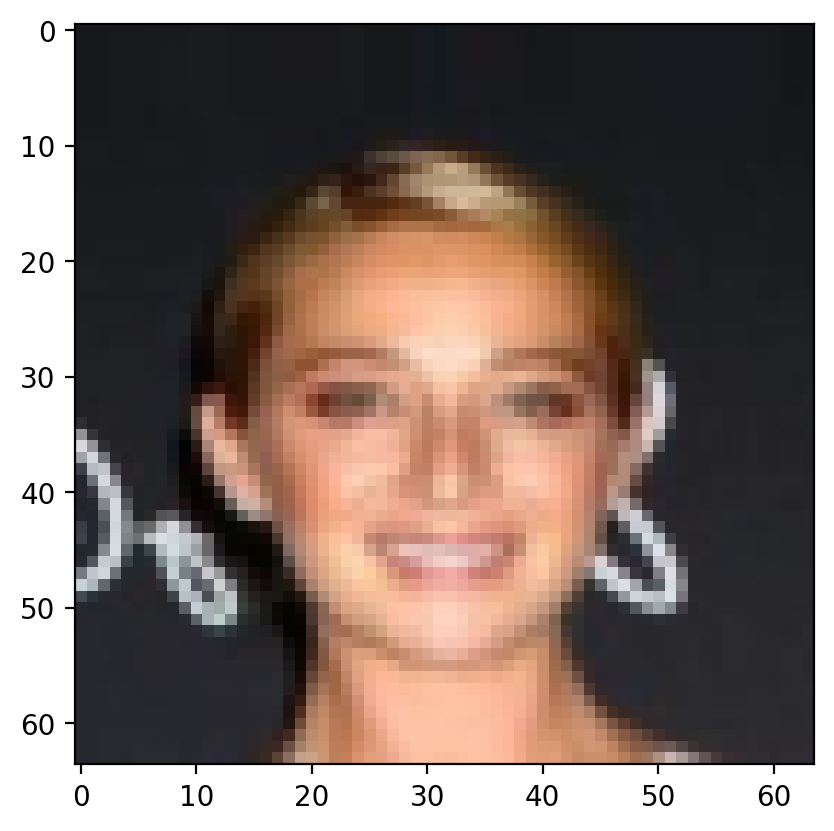

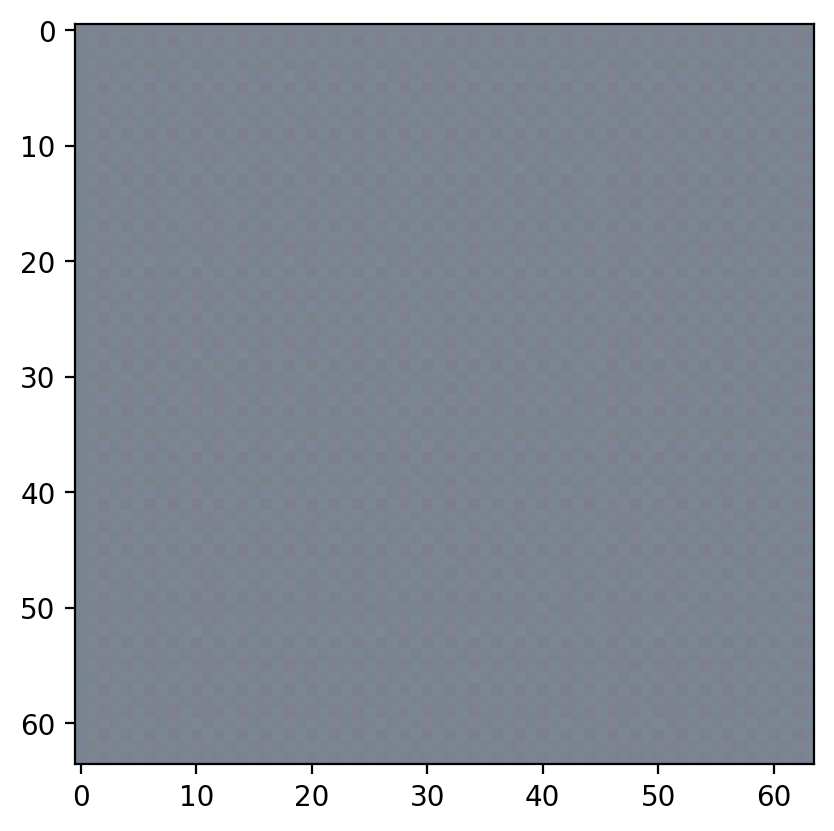

In [ ]:
my_dec = decoder(dimz=2)

x_mean = my_dec.decode(mu_z).detach()

imshow(i[0,:,:,:])

imshow(x_mean[0,:,:,:])

Observe that, since the mean `x_mean` is so different from the real image, then the real image is **extremely unlikely** in the distribution $p(\mathbf{x}|\mathbf{z})$. The model will never generate it by sampling.

For one image `x`, the following function evaluates the log-likelihood of an independent Gaussian distribution given the mean and the diagonal covariance matrix. In the function, both `x` and `mu_x` are passed as images and internally stacked to vectors. `var_x` is a constant. Recall that `var_x` is a constant vector of 0.1 elements.



In [ ]:
def eval_Gaussian_LL(x,mu_x,var_x):

    # x is a mini-batch of images. It has dimension [Batch,3,dimx,dimx]

    # mu_x is a mini-batch of reconstructed images. It has dimension [Batch,3,dimx,dimx]

    # var_x is a torch constant

    D = x.shape[1] * x.shape[2] * x.shape[3]   # Dimension of the image

    x = x.reshape(-1, D)

    mu_x = mu_x.reshape(-1, D)

    var_x = torch.ones_like(mu_x) * var_x

    # Constant term in the gaussian distribution
    cnt = D * np.log(2 * np.pi) + torch.sum(torch.log(var_x), dim=-1)

    # log-likelihood per datapoint

    logp_data = -0.5 * (cnt + torch.sum((x - mu_x) * var_x ** -1 * (x - mu_x), dim=-1))

    # Accumulated Gaussian log-likelihood for all datapoints in the batch
    logp = torch.sum(logp_data)

    return logp,logp_data

> **Exercise:** Compute the log-likelihood of one real image given `x_mean` computed above and `var_x=0.1`.

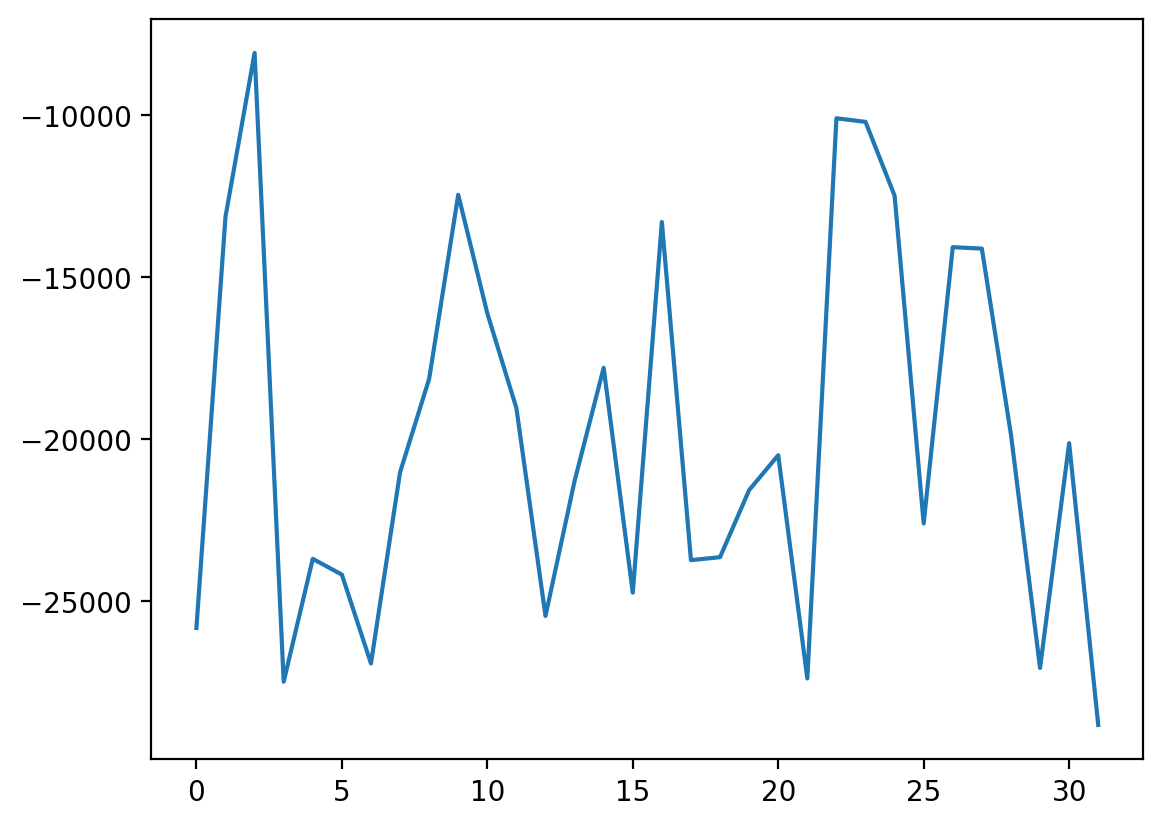

In [ ]:
var_x = 0.1

logp,logp_data = eval_Gaussian_LL(i, x_mean, var_x=0.1)

plt.plot(np.arange(0,32),logp_data)

## The variational autoencoder class

The following class puts together the VAE encoder & decoder and also defines the ELBO lower bound. We will extend it later to incorporate training methods.

> **Exercise**: complete the following code.

In [ ]:
class VAE(nn.Module):

    def __init__(self,dimz,channels=3,var_x=0.1):

        super().__init__()

        self.var_x = var_x

        self.dimz = dimz

        # We create an encoder network

        self.encoder = encoder(dimz, channels, var_x)

        # We create a decoder network

        self.decoder = decoder(dimz, channels, var_x)

    def forward(self,x):

        # In the forward method, we return the mean and variance
        # given by the encoder network and also the reconstruction mean
        # given by the decoder network using a sample from the
        # encoder's posterior distribution.

        mu_z,var_z,sample_z = self.encoder.encode_and_sample(x)

        # Decoder provides the mean of the reconstruction

        mu_x = self.decoder.decode(sample_z)

        return mu_x,mu_z,var_z

    # Reconstruction + KL divergence losses summed over all elements and batch

    def loss_function(self, x, mu_x, mu_z, var_z):

        # We evaluate the loglikelihood in the batch using the function provided above

        logp,_ = eval_Gaussian_LL(x, mu_x, self.var_x)

        # KL divergence between q(z) and N()
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114

        KLz = -0.5 * torch.sum(1 + torch.log(var_z) - mu_z.pow(2) - var_z)

        # To maximize ELBO we minimize loss (-ELBO)
        return -logp + KLz, -logp, KLz




> **Exercise:** Create a VAE object for `dimz=2` and evaluate the ELBO using `mu_z`, `var_z`, and `x_mean` computed above.

In [ ]:
my_vae = VAE(2)

print(my_vae.loss_function(i,x_mean,mu_z,var_z))


(tensor(634908.3125, grad_fn=<AddBackward0>), tensor(634906.3750), tensor(1.9465, grad_fn=<MulBackward0>))


## Incorporating a training method

The following class completes the implementation of the VAE. **You do not have to edit anything**, but it is highly recommended to go through the code. It is actually very similar to the training classes we have been implementing. Only three points to remark:


- Since training is pretty slow (every epoch can take a few minutes), we save the model every few minibatches. User indicates the saving path using the `save_folder` argument.
- I have introduced a `restore` flag. When set it to true, we load the model parameters from a file saved in the `save_folder` argument.
- The class also incorporates a method to sample from the generative model. Namely, create new images. To this end, we sample $\mathbf{z}$ from $p(\mathbf{z}) = \mathcal{N}(0,I)$ and then we return the mean of $p(\mathbf{x}|\mathbf{z})$.

In [ ]:
class VAE_extended(VAE):

    def __init__(self, dimz=2,  channels=3, var_x=0.1,lr=1e-3,epochs=20,save_folder='./',restore=False):

        super().__init__(dimz,channels=3,var_x=0.1)

        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs

        self.save_folder = save_folder

        if(restore==True):
            state_dict = torch.load(self.save_folder+'VAE_checkpoint.pth')
            self.load_state_dict(state_dict)

        self.loss_during_training = []
        self.reconstruc_during_training = []
        self.KL_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def trainloop(self,trainloader):

        nims = len(trainloader.dataset)

        self.train()

        for e in range(int(self.epochs)):

            train_loss = 0
            train_rec = 0
            train_kl_l = 0

            idx_batch = 0

            for images, labels in trainloader:

                images = images.to(self.device)

                self.optim.zero_grad()

                mu_x, mu_z, var_z = self.forward(images)

                loss, rec, kl_l = self.loss_function(images,mu_x, mu_z, var_z)

                loss.backward()

                train_loss += loss.item()
                train_rec += rec.item()
                train_kl_l += kl_l.item()

                self.optim.step()

                if(idx_batch%10==0):

                    torch.save(self.state_dict(), self.save_folder + 'VAE_checkpoint.pth')

                idx_batch += 1

            self.loss_during_training.append(train_loss/len(trainloader))
            self.reconstruc_during_training.append(train_rec/len(trainloader))
            self.KL_during_training.append(train_kl_l/len(trainloader))

            if(e%1==0):

                torch.save(self.state_dict(), self.save_folder + 'VAE_checkpoint.pth')
                print('Train Epoch: {} \tLoss: {:.6f}'.format(e,self.loss_during_training[-1]))


    def sample(self,num_imgs):

        with torch.no_grad():

            eps = torch.randn([num_imgs,self.dimz]).to(self.device)

            x_sample = self.decoder.decode(eps)

            return x_sample.to("cpu").detach()

# Validate a pre-trained model

First, we're going to see a VAE model in action. In the file `VAE_checkpoint.pth` linked in Aula Global, I give you the parameters of a VAE with `dim_z=50` trained for 200 epochs with `var_x=0.1`, `lr=1e-3`.

> **Exercise**: Create a VAE with the parameters contained in the file `VAE_checkpoint.pth`. To do so, instantiate the class `VAE_extended` with the `restore_flag` set to `True`.

In [ ]:
path_to_save = '/content/drive/MyDrive/UC3M/1º MASTER/DEEP LEARNING/Lab 1. Deep probabilistic modeling-20231114/' # UPDATE THIS ACCORDING TO YOUR PATH!
my_vae = VAE_extended(50, save_folder = path_to_save, restore=True)

> **Exercise:** Using the method `sample` from the clase `VAE_extended`, generate 20 images from the probabilistic model. **Note these are images created by our model! They correspond to people that do not exist!**.

There are many variants of VAEs that quite improve these results, but even this vanilla VAE we have implemented does a pretty god job! Despite the images contain lots of artifacts, note that the images contain lots of very realistic details. Also note how the model tries to vary the features of the images (hair, background, smiles etc ...).

In [ ]:
x = my_vae.sample(20)

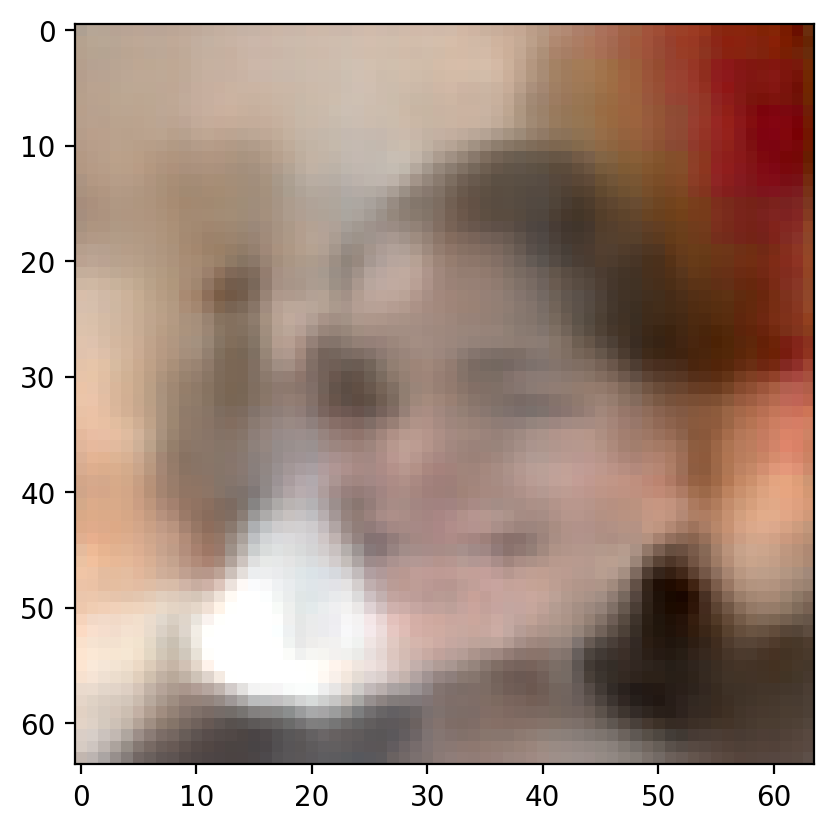

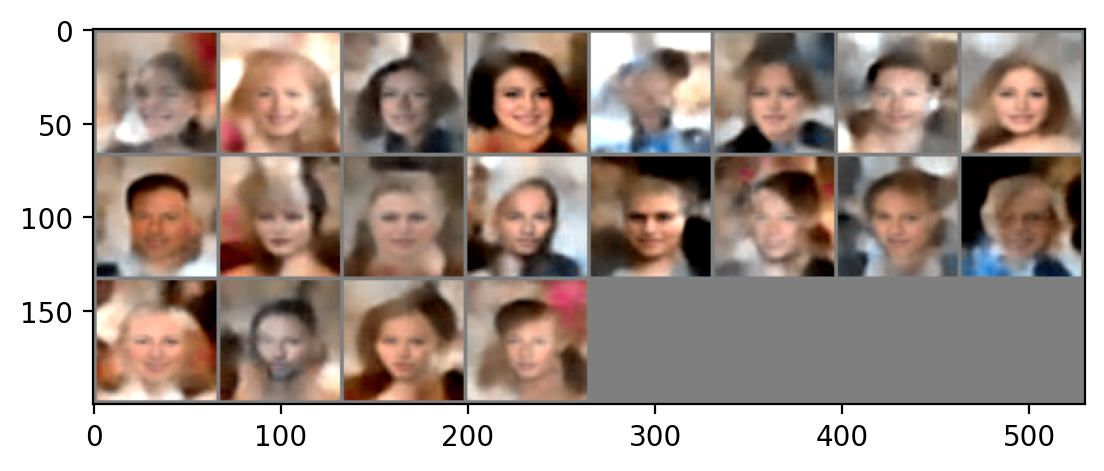

In [ ]:
imshow(x[0,:,:,:])

imshow(torchvision.utils.make_grid(x))

> **Exercise:** Compare a real image versus its reconstruction. Note that the model is by default save in a GPU if available, so you have to move the images there. To visualize reconstructed images, you have to move the result of the decoder back to CPU.

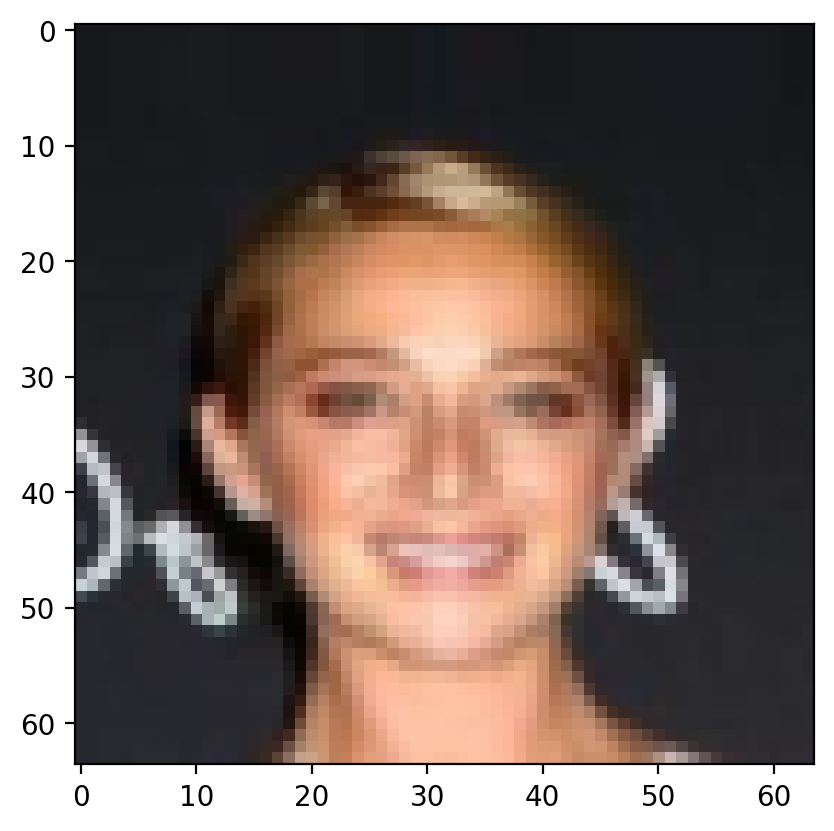

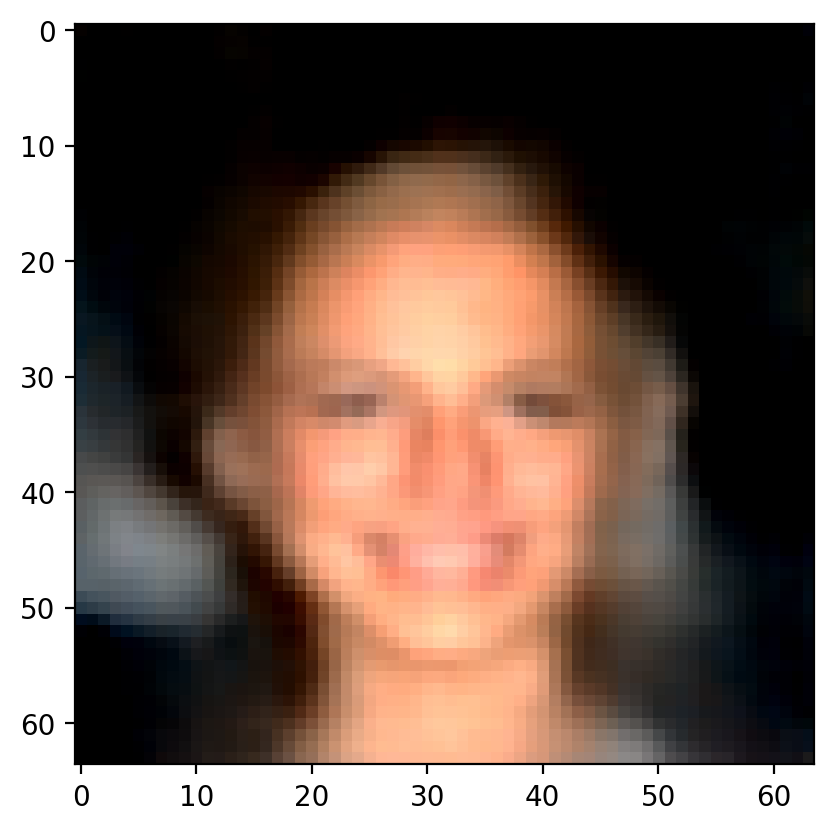

In [ ]:

z_batch,_,_ = my_vae.encoder.encode_and_sample(i.to("cuda"))

x_reconstructed = my_vae.decoder.decode(z_batch).detach()

# We plot he original image
imshow(i[0,:,:,:])

# And the reconstruction
imshow(x_reconstructed.cpu()[0,:,:,:])


> Using the VAE, we can also *interpolate* between images. Namely, given the latent representation $\mathbf{z}_1$ and $\mathbf{z}_2$ of two images, we can visualize the images that correspond to different linear interpolations between both latent points. To this end, given $w=[0,0.1,0.2, ...,1]$, will visualize the mean of $p(\mathbf{x}|\mathbf{z})$ for

$$z = (1-w)\mathbf{z}_1+w\mathbf{z}_2$$

**Exercise:** Complete the following code to interpolate between two images

torch.Size([3, 64, 64])


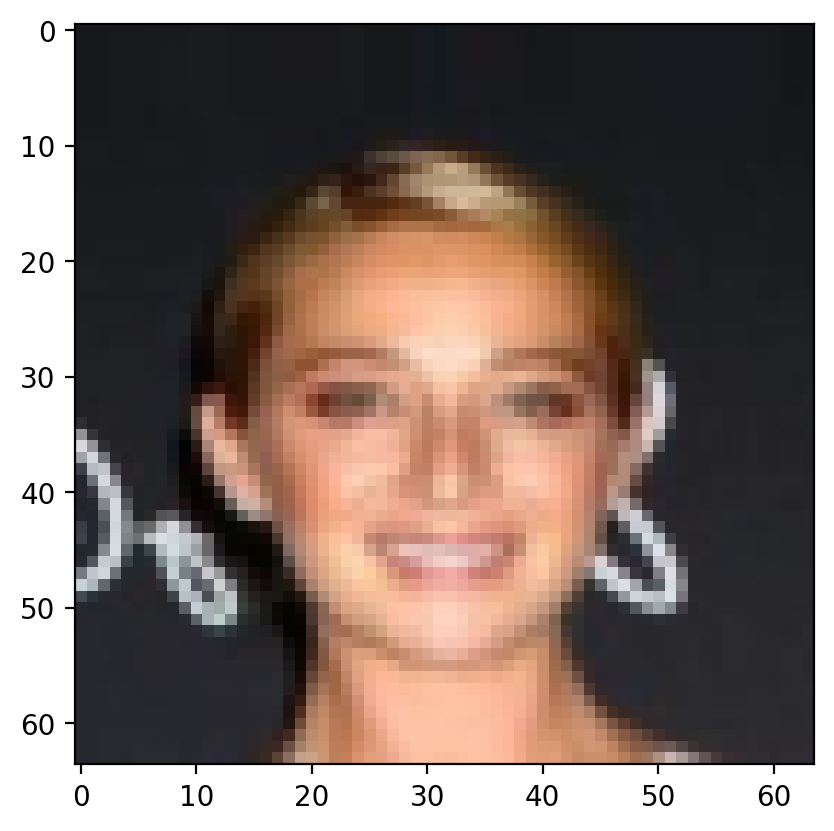

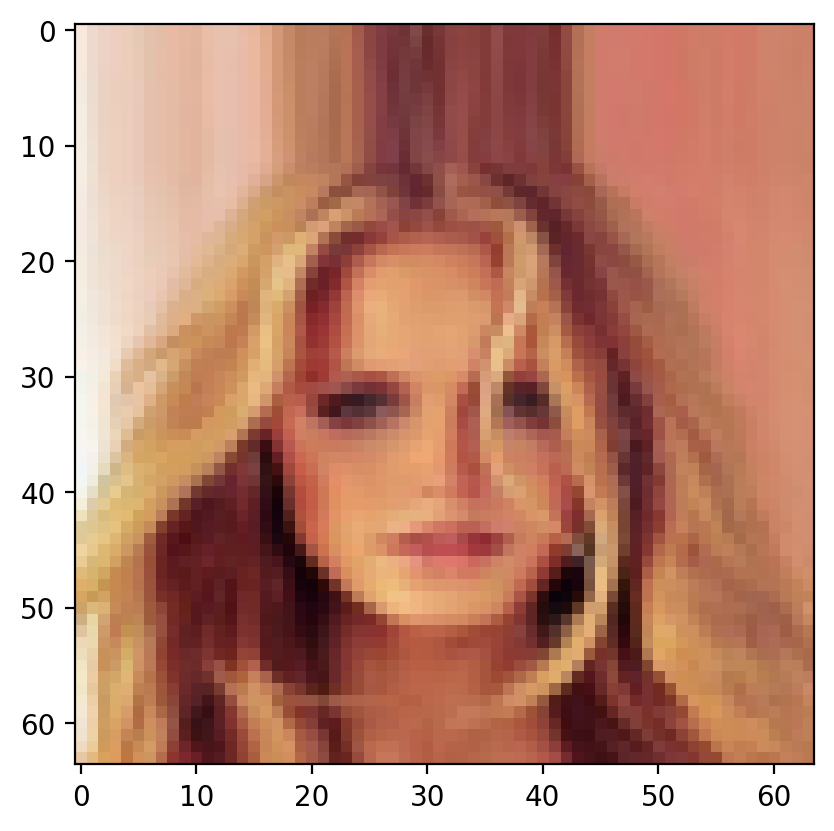

In [ ]:
# Lets visualize the images to interpolate

img_1 = i[0,:,:,:]
img_2 = i[1,:,:,:]

print(img_1.shape)
imshow(img_1)

imshow(img_2)


In [ ]:
# z_1 and z_2 are saved in z_batch, computed in the previous exercise

z_1 = z_batch[0,:]
z_2 = z_batch[1,:]

# Linear interpolation

weight = torch.Tensor(1.0-np.arange(0,10,1)/10)

reconstructed_image = [my_vae.decoder.decode(z_1*w+z_2*(1-w)).to('cpu').detach() for w in weight]

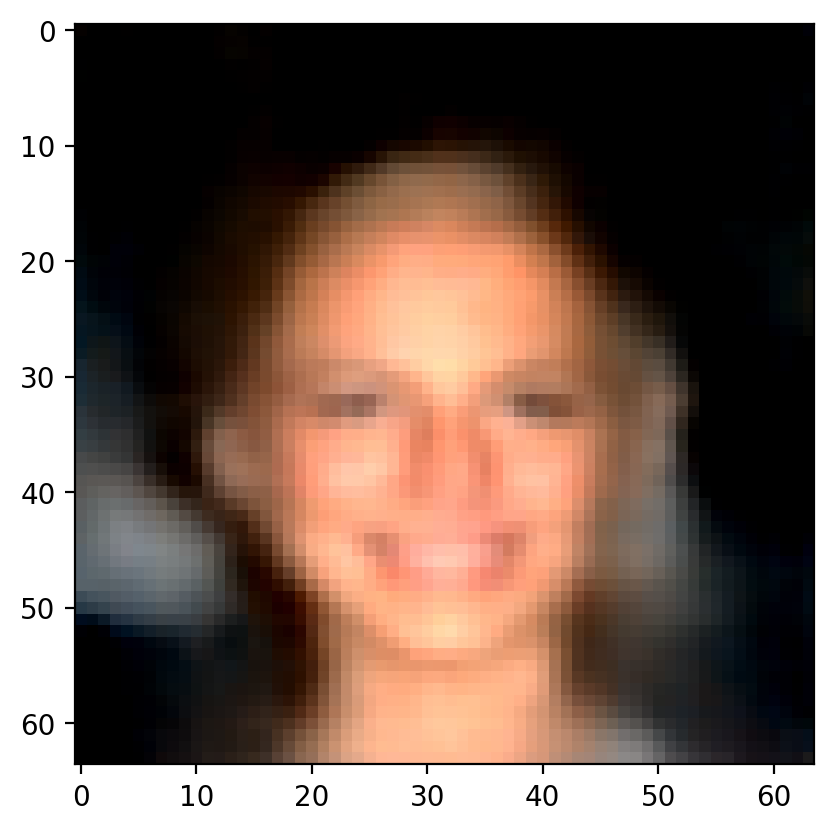

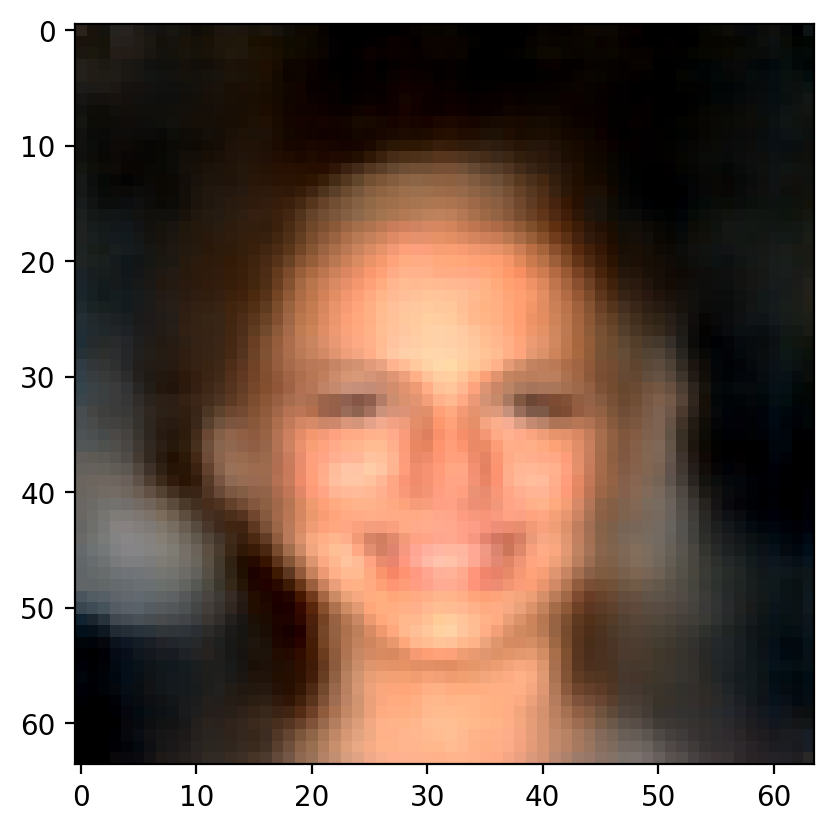

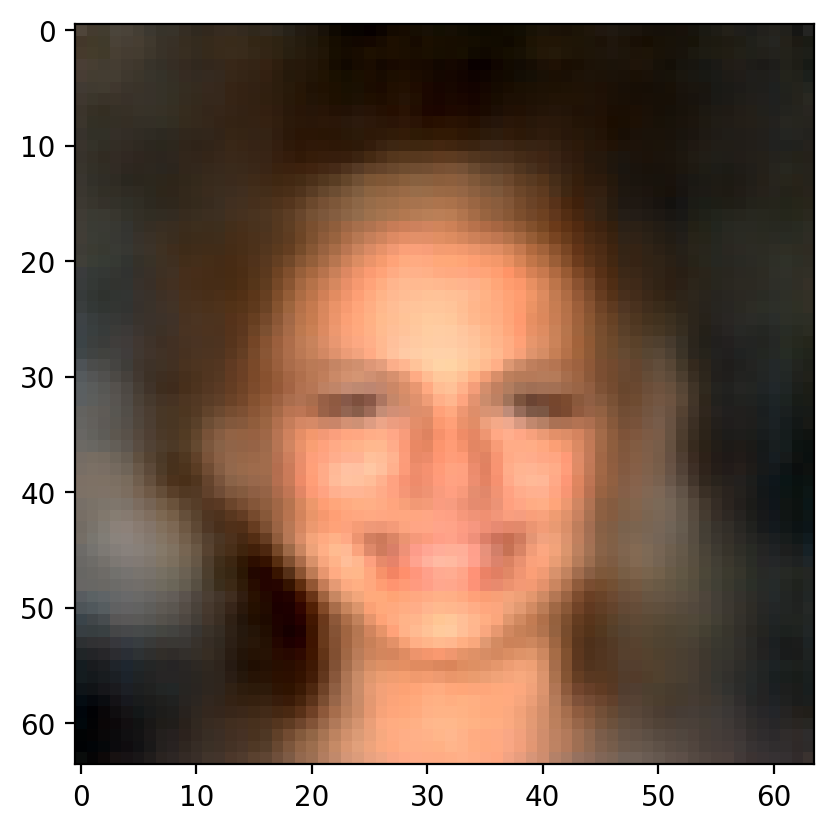

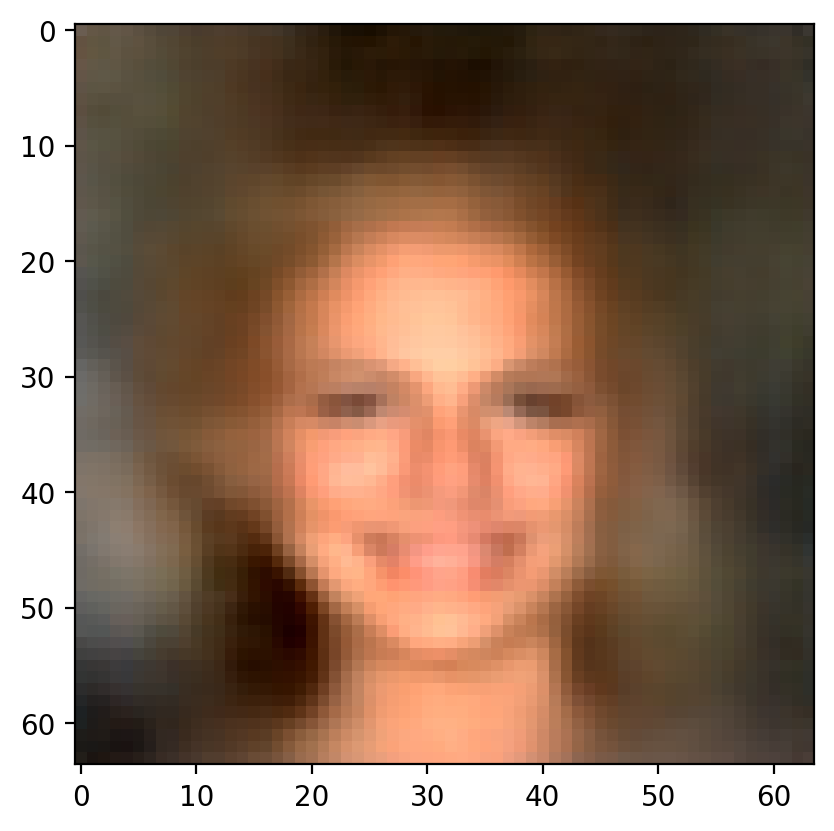

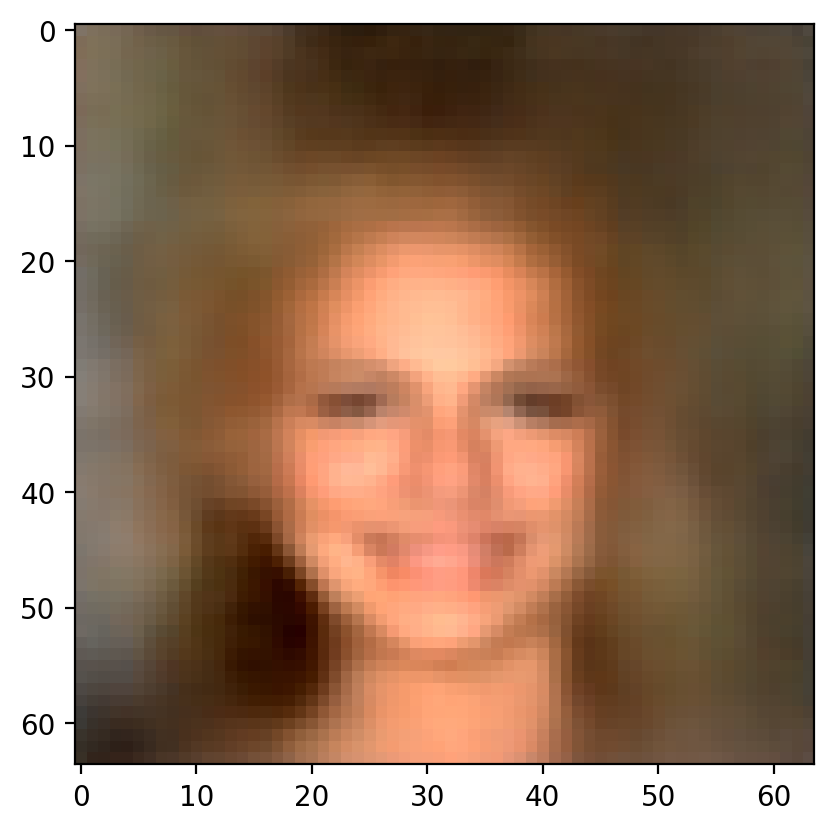

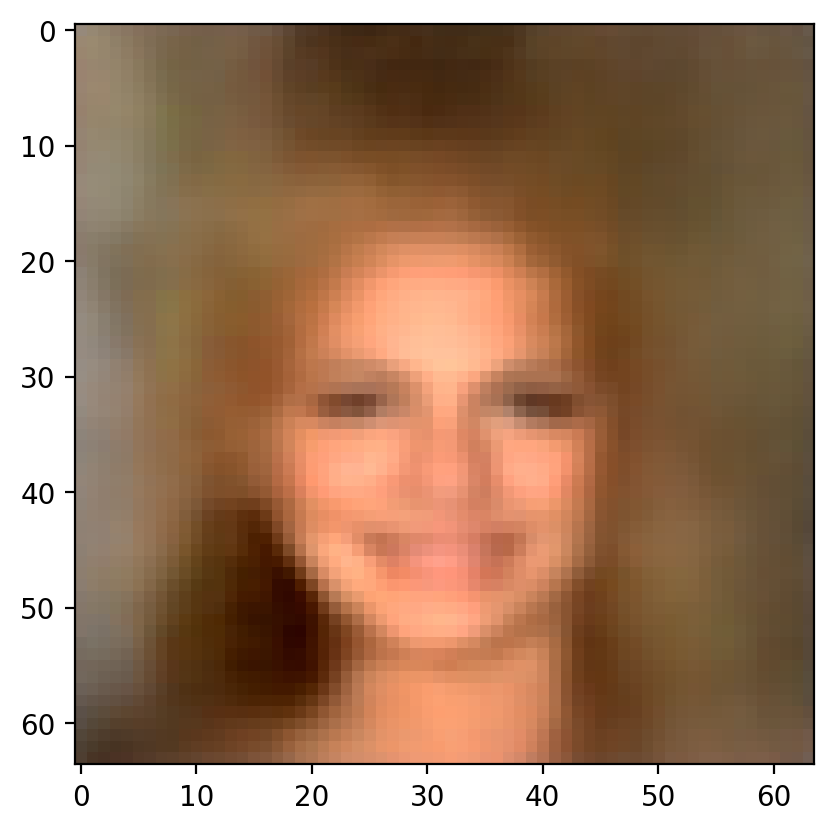

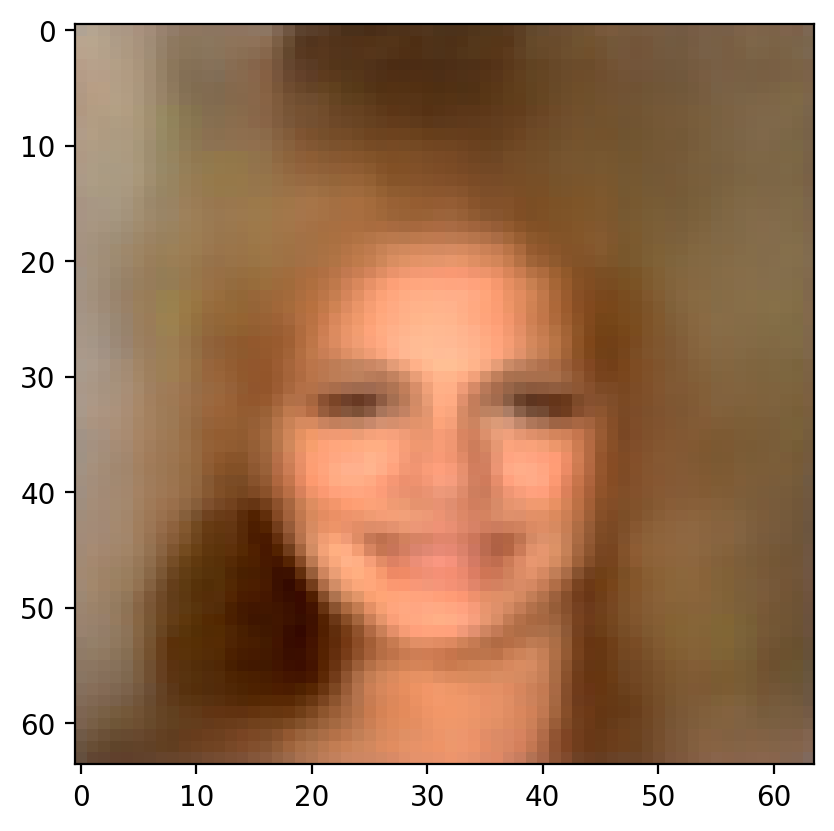

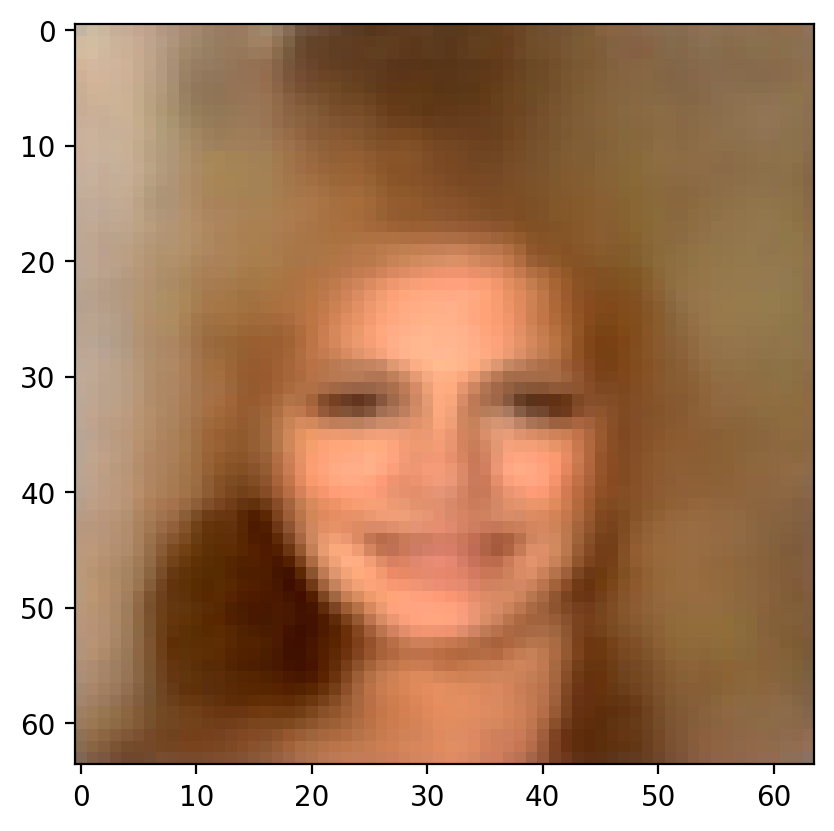

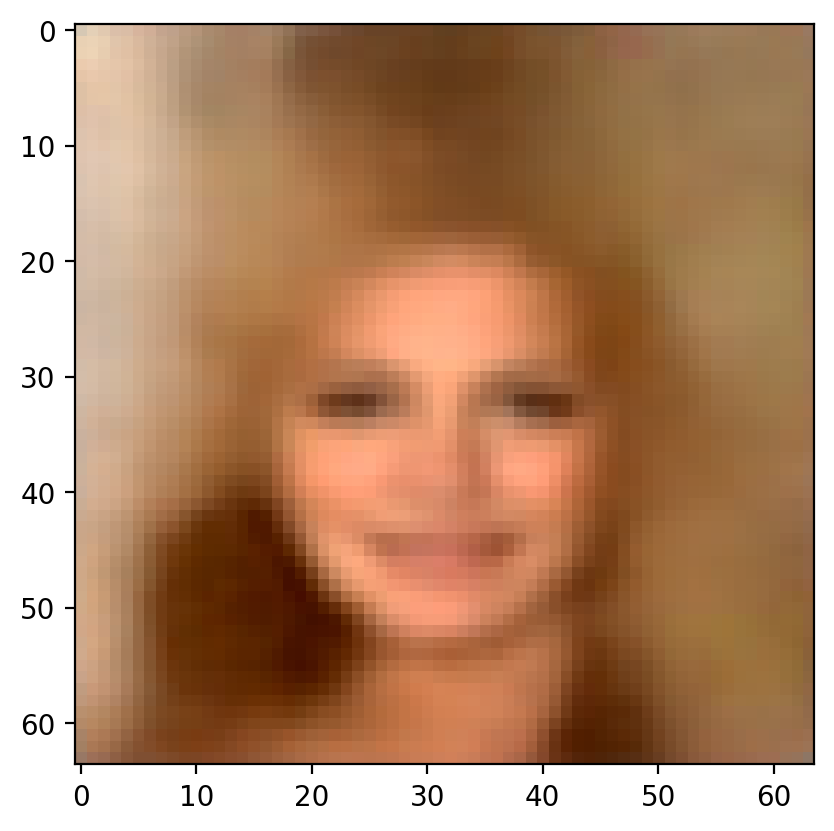

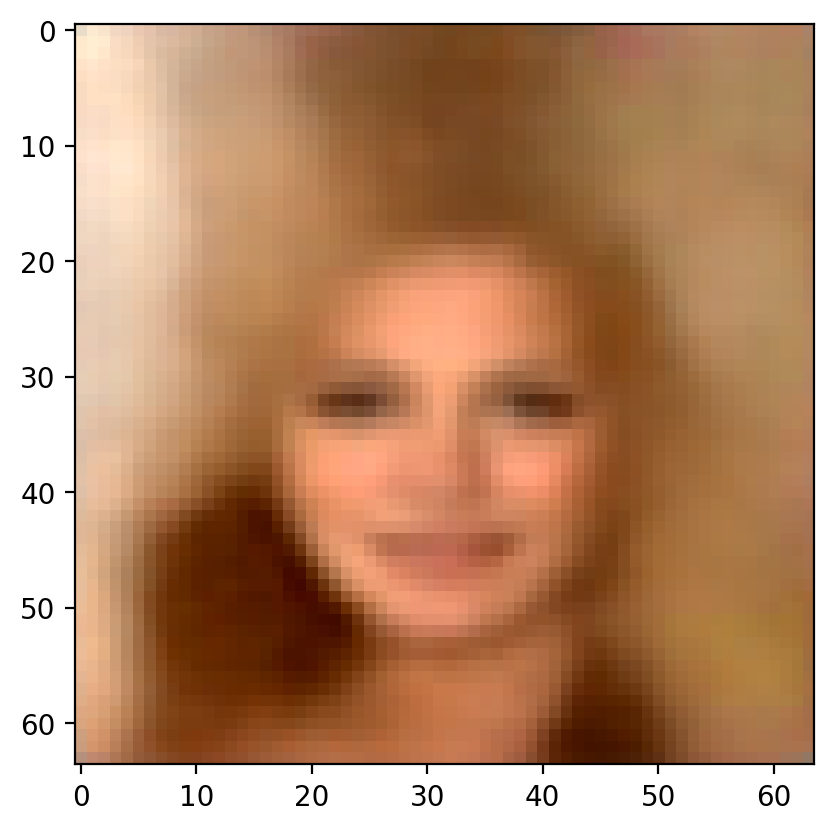

In [ ]:
# Visualize all images in the reconstructed_image list

for im in reconstructed_image:
    imshow(im[0, :, :, :])

>**Exercise:** Using TSNE over `z_batch``, show how real images are projected in a 2D space. The following function is handy (it was already used in the previous lab)

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def rescale(img):
    img = img / 2 + 0.5     # unnormalize to pot
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

def plot_latent_space_with_images(images,latent,xmin=-150,xmax=150,ymin=-150,ymax=150):

    # images --> Minibatch of images (numpy array!)
    # latent --> Matrix of 2D representations (numpy array!)

    f, ax = plt.subplots(1,1,figsize=(8, 8))
    # ax is a figure handle
    ax.clear()
    for i in range(len(images)):
        im = OffsetImage(rescale(images[i,:,:,:]))
        ab = AnnotationBbox(im, latent[i,:],frameon=False)
        ax.add_artist(ab)
    #We set the limits according to the maximum and minimum values found for the latent projections
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_title('Latent space Z with Images')

In [ ]:
from sklearn.manifold import TSNE

# Apply TSNE over z_batch

latent_tsne = TSNE(n_components=2).fit_transform(z_batch.to('cpu').detach())

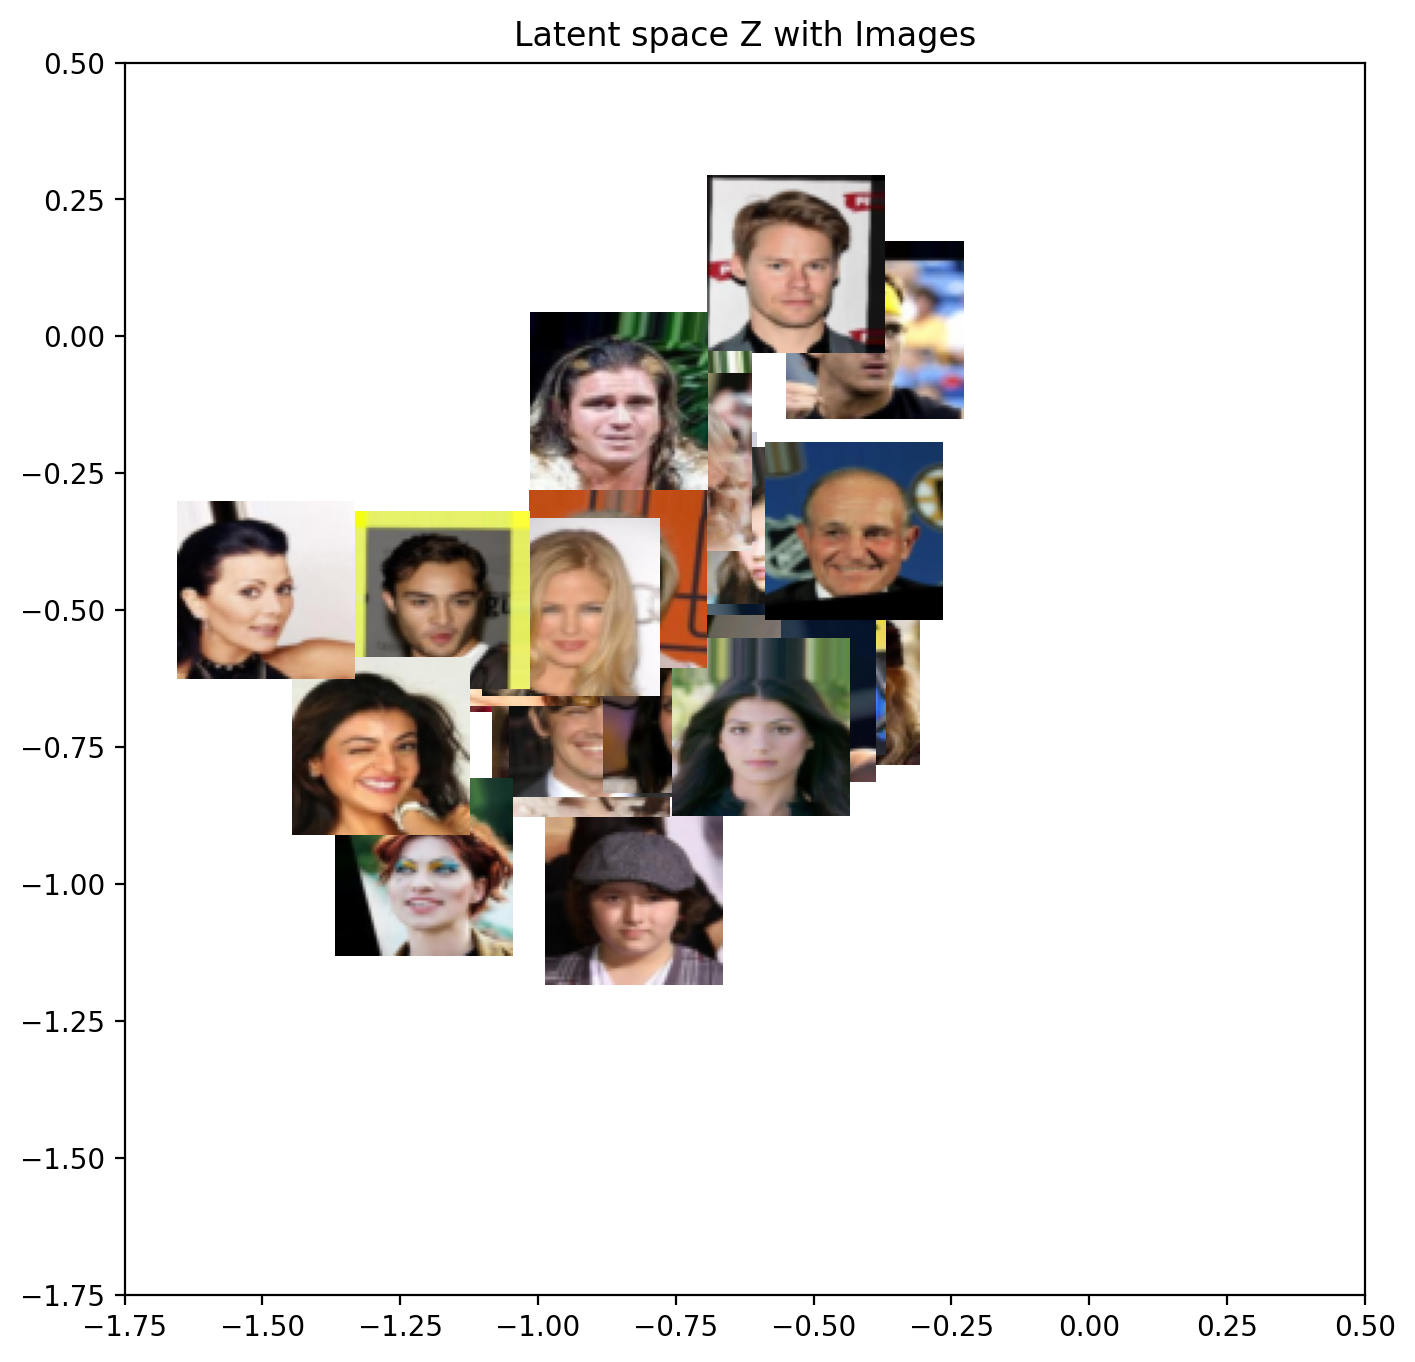

In [ ]:
plot_latent_space_with_images(i, latent_tsne, -1.75, 0.5, -1.75, 0.5)

## Train the VAE from scratch

Just to finish, train your own VAE from zero for a few epochs and generate images from the model.

In [ ]:
my_vae = VAE_extended(2)
my_vae.trainloop(trainloader)

Train Epoch: 0 	Loss: 311500.218344
Train Epoch: 1 	Loss: 249860.235459
Train Epoch: 2 	Loss: 244438.589866
Train Epoch: 3 	Loss: 242078.260251
Train Epoch: 4 	Loss: 239268.009348
Train Epoch: 5 	Loss: 237325.781476
Train Epoch: 6 	Loss: 235825.790282
Train Epoch: 7 	Loss: 234731.749774
Train Epoch: 8 	Loss: 234994.206331
Train Epoch: 9 	Loss: 235985.862355
Train Epoch: 10 	Loss: 232936.328170
Train Epoch: 11 	Loss: 230425.395322
Train Epoch: 12 	Loss: 229913.055816
Train Epoch: 13 	Loss: 228731.867549
Train Epoch: 14 	Loss: 230760.865607
Train Epoch: 15 	Loss: 227599.885025
Train Epoch: 16 	Loss: 226877.493452
Train Epoch: 17 	Loss: 227180.033689
Train Epoch: 18 	Loss: 227111.573293
Train Epoch: 19 	Loss: 225502.534005


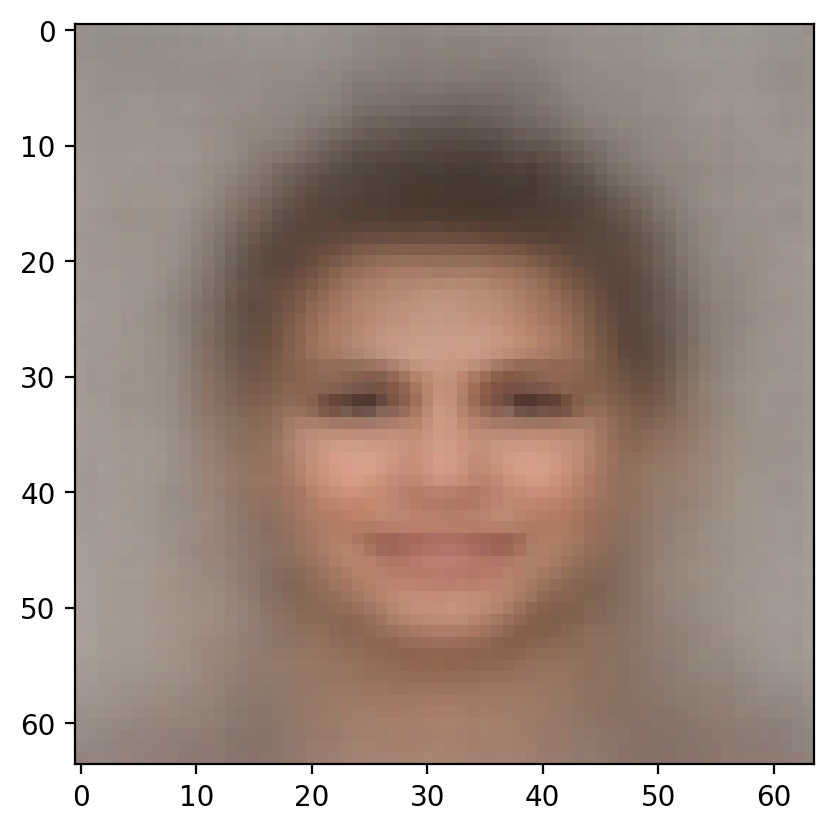

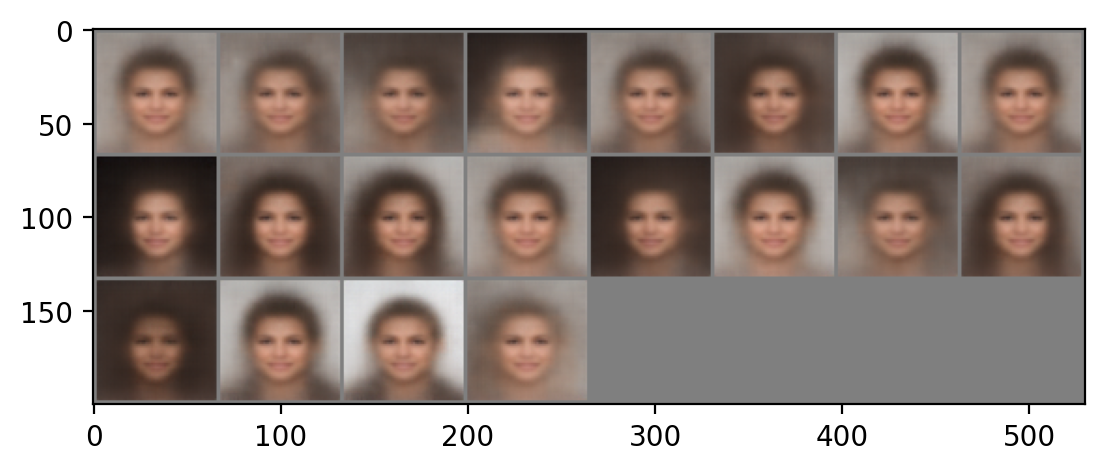

In [ ]:
x = my_vae.sample(20)

imshow(x[0,:,:,:])

imshow(torchvision.utils.make_grid(x))